In [1]:
pwd

'/mmfs1/data/bergerar/BC-MRI-ADHD/Code'

In [2]:
import os 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from make_models import get_MRI_VAE_3D,get_MRI_CVAE_3D
from tqdm import tqdm 

2022-06-22 13:19:07.580539: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/9.2.0/lib:/cm/local/apps/gcc/9.2.0/lib64:/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-06-22 13:19:07.580572: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
stuff = np.load('../Assets/brain_array-440.npz')
print(list(stuff.keys()))

data = stuff['data']
control = stuff['controls']
patients = stuff['patients']
n = data.shape[0]
print(data.shape)
data[patients,:,:,:].shape
data[patients].shape

['data', 'controls', 'patients']
(440, 64, 64, 64)


(179, 64, 64, 64)

In [16]:
#data

In [14]:
patients

(440,)

In [58]:
# data loader
class cvae_data_loader_adhd():
    ''' this is the info'''
    def __init__(self,data,patients,batch_size=32):
    
        self.data = data
        
        self.n = data.shape[0]
        self.epoch = -1
        self.batch_size = batch_size
        
        self.new_epoch()
        self.n_batches = int(np.floor(min((len(self.asd_idxs),len(self.td_idxs)))/self.batch_size)) # How many batches fit, take the min(n_ASD,n_TD) then divide by batch size
        
    def new_epoch(self):

        self.asd_idxs = np.nonzero(patients==True)[0] # idxs of patients
        self.td_idxs = np.nonzero(patients==False)[0] # idxs of TDs
        
        self.asd_idxs = np.random.permutation(self.asd_idxs)
        self.td_idxs = np.random.permutation(self.td_idxs)
        
        self.epoch += 1
        self.b = 0
        
        
    def get_batch(self):
        self.b += 1
        
        if self.b==self.n_batches:
            self.new_epoch()
        
        self.batch_asd_idx = self.asd_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        self.batch_td_idx = self.td_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        # go through the patients and controls in batch size chunks
        # batch_indeces = all_indices[batch number * batch size : batch number * batch size + batch size]
        
        self.batch_asd = self.data[self.batch_asd_idx,:,:,:]
        self.batch_td = self.data[self.batch_td_idx,:,:,:]
        
        _,counts = np.unique(np.hstack((self.batch_asd_idx,self.batch_td_idx)),return_counts=True)
        assert all(counts==1),'not all unique, somethings wrong'
        
        return self.batch_asd,self.batch_td

In [64]:
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1,
                    disentangle=False,
                    gamma=1,
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)

In [65]:
data_loader = cvae_data_loader_adhd(data,patients)

In [73]:
range(n_epochs)

range(0, 2)

In [76]:
# Make sure you have GPU enabled

n_epochs = 2
n_batches = data_loader.n_batches # dataloader calcs how many batches
loss = []
for epoch in tqdm(range(n_epochs)):
    for batch in range(n_batches):
        adhd_batch, td_batch = data_loader.get_batch()
        l = cvae.train_on_batch([adhd_batch,td_batch])
        loss.append(l)

100%|████████████████████████████████████████████| 2/2 [05:15<00:00, 157.78s/it]


In [49]:
# for i in tqdm(range(5)):
#     cvae.train_on_batch([data_batch_patients,data_batch_control])

100%|██████████| 5/5 [00:58<00:00, 11.78s/it]


In [50]:
predictions = cvae.predict([data_batch_patients,data_batch_control])

Text(0.5, 1.0, 'prediction')

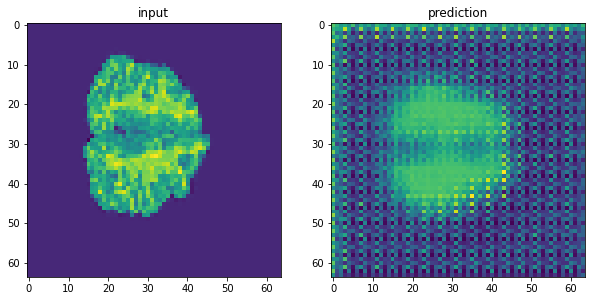

In [52]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_batch_patients[0,:,:,32])
plt.title('input')
plt.subplot(1,2,2)
plt.imshow(predictions[0][0,:,:,32,0])
plt.title('prediction')

In [ ]:
# Make a Data loader

#dataloader_vae.get_batch()
#dataloader_cae.get_patient_batch()
#dataloader_cae.get_control_batch()